# Small crystalline dataset Phase Retrieval

> Georgios Varnavides | Oct 21 2025  
>
> Sample: Thin strontium titanate (STO)  
> Sampling conditions: Nyquist  
> Imaging conditions: 20 mrad, in-focus, defocus, coma, defocus + coma  
> Dose conditions: 1e8 and 1e4 e/A2

In [1]:
import quantem as em
import numpy as np

## Dataset

Import 6D dataset (note first two dimensions are the aberrations axes)

In [2]:
dataset = em.core.io.load("../data/STO_20mrad_C10_C21_Nyquist.zip")
dataset

Dataset(shape=(2, 2, 32, 32, 192, 192), dtype=float32, name='6d dataset')
  sampling: [5.000000e+01 5.000000e+03 1.221875e-01 1.221875e-01 8.391939e-01
 8.391939e-01]
  units: ['A', 'A', 'A', 'A', 'mrad', 'mrad']
  signal units: 'arb. units'

In [3]:
energy = 300e3
semiangle_cutoff = 20

aberrations=[
    [
        {"C10":C10,"C21":C21,"phi21":-0.8}
        for C21 in (0,dataset.sampling[1])
    ]
    for C10 in (0,dataset.sampling[0])
]
aberrations_flat = [aberrations[0][0], aberrations[1][0], aberrations[1][1]]
aberrations_flat

[{'C10': 0, 'C21': 0, 'phi21': -0.8},
 {'C10': 50.0, 'C21': 0, 'phi21': -0.8},
 {'C10': 50.0, 'C21': 5000.0, 'phi21': -0.8}]

## Finite Poisson Dose

In [4]:
def add_poisson_noise(
    dataset,
    electrons_per_area,
):
    if electrons_per_area == np.inf:
        return dataset
    electrons_per_probe = electrons_per_area * dataset.sampling[:2].prod()
    
    dataset_noisy = dataset.copy()
    dataset_noisy.array = np.random.poisson(dataset.array * electrons_per_probe)
    return dataset_noisy

In [5]:
np.random.seed(2025)
noisy_datasets = [
    [
        add_poisson_noise(
            dataset[index],
            dose
        ) for dose in (1e8,1e4)
    ]
    for index in ((0,0),(1,0),(1,1))
]

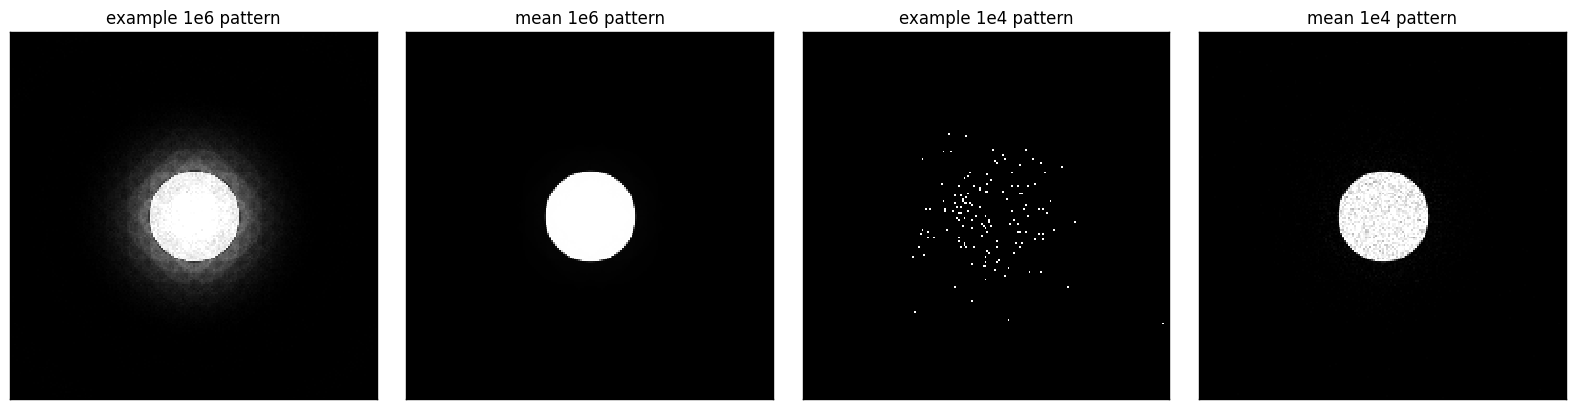

In [6]:
em.visualization.show_2d(
    [
        noisy_datasets[0][0][0,0].array,
        noisy_datasets[0][0].mean((0,1)),
        noisy_datasets[0][1][0,0].array,
        noisy_datasets[0][1].mean((0,1)),
    ],
    title=[
        "example 1e6 pattern","mean 1e6 pattern","example 1e4 pattern","mean 1e4 pattern"
    ]
);

## Direct Ptychography

We start by exploring weak-phase object phase retrieval using the `em.diffractive_imaging.DirectPtychography` class. We make a helper class to initialize a ptycho object for specific datasets.

In [7]:
def direct_ptycho_object(
    noisy_dataset,
    aberration_coefs,
    device='cpu',
):
    ds = noisy_dataset
    data = np.fft.ifftshift(ds.array,axes=(-1,-2))
    
    mean_dp = data.mean((0,1))
    bf_mask = mean_dp > mean_dp.max()*0.5
    
    bf_mask_dataset = em.core.datastructures.Dataset2d.from_array(
        bf_mask,
        name="BF mask",
        units=ds.units[-2:],
        sampling=ds.sampling[-2:],
    )
    
    # vbf_stack
    vbf_stack = data[..., bf_mask]
    vbf_stack = vbf_stack / vbf_stack.mean((0, 1))
    vbf_stack = np.moveaxis(vbf_stack, (0, 1, 2), (1, 2, 0))
    
    vbf_dataset = em.core.datastructures.Dataset3d.from_array(
        vbf_stack,
        name="vBF stack",
        units=("index",) + tuple(ds.units[:2]),
        sampling=(1,) + tuple(ds.sampling[:2]),
    )
    
    ptycho = em.diffractive_imaging.DirectPtychography.from_virtual_bfs(
        vbf_dataset,
        bf_mask_dataset,
        energy=energy,
        semiangle_cutoff=semiangle_cutoff,
        rotation_angle=0,
        aberration_coefs=aberration_coefs,
        device=device,
    )
    
    return ptycho

In [8]:
direct_ptychography_classes = [[direct_ptycho_object(x, aberrations_flat[index],device='gpu') for x in sublist] for index,sublist in enumerate(noisy_datasets)]

### Deconvolution Kernel

Direct ptychography essentially attempts to deconvolve the effect of the probe from the dataset. In quantem, we have implemented three such kernels:
- 'none' or None: incoherent BF STEM
- 'quadratic' or 'parallax': the parallax approximation to direct ptychography
- 'full' or 'ssb': the double-overlap weighted kernel used in direct ptychography

  0%|          | 0/1757 [00:00<?, ?it/s]

  0%|          | 0/1757 [00:00<?, ?it/s]

  0%|          | 0/1757 [00:00<?, ?it/s]

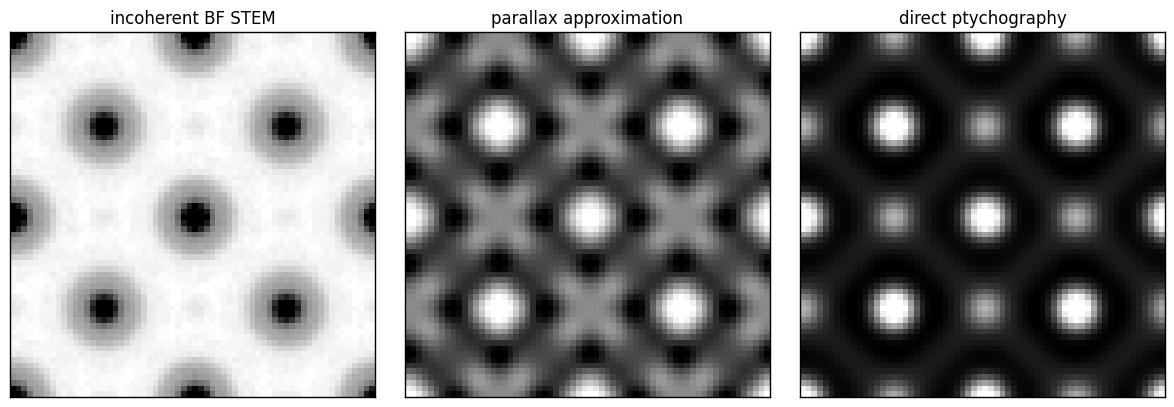

In [9]:
incoherent_bf_stem_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='none').obj
parallax_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='parallax').obj
direct_ptychography_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='full').obj
direct_ptychography_obj_amplitude = direct_ptychography_classes[1][0].corrected_stack_amplitude.mean(0).cpu().numpy()

em.visualization.show_2d(
    [
        np.tile(incoherent_bf_stem_obj,(2,2)),
        np.tile(parallax_obj,(2,2)),
        np.tile(direct_ptychography_obj,(2,2))
    ],
    title=["incoherent BF STEM","parallax approximation","direct ptychography"]
);

Note also that for `deconvolution_kernel='full'` we also obtain the amplitude of the reconstruction

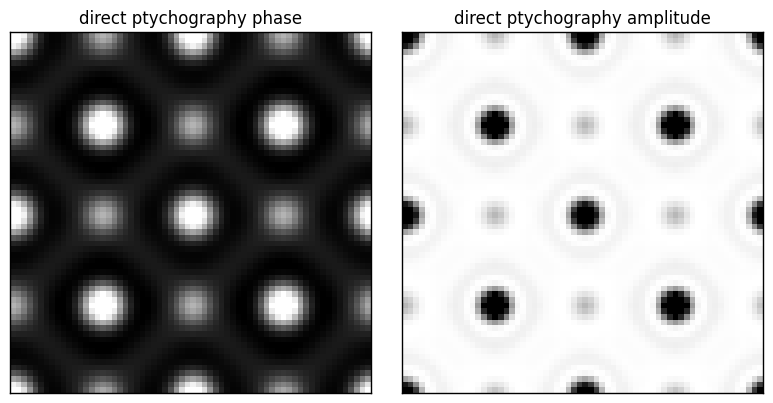

In [11]:
em.visualization.show_2d(
    [
        np.tile(direct_ptychography_obj,(2,2)),
        np.tile(direct_ptychography_obj_amplitude,(2,2))
    ],
    title=["direct ptychography phase","direct ptychography amplitude"]
);

### Center of Mass Weighting

After deconvolution, we can weight the virtual BFs with the detector coordinates and integrate to obtain an "iCOM"-like reconstruction.
- for `deconvolution_kernel = 'none'`, we obtain the usual iCOM reconstruction
- for `deconvolution_kernel = 'quadratic'`, we obtain the complement to the parallax reconstruction, i.e. the BF image modulated by $\cos[\chi]$ (as opposed to $\sin[\chi]$)
- for `deconvolution_kernel = 'full'`, we obtain an iCOM reconstruction, had the data been collected in focus

  0%|          | 0/1757 [00:00<?, ?it/s]

  0%|          | 0/1757 [00:00<?, ?it/s]

  0%|          | 0/1757 [00:00<?, ?it/s]

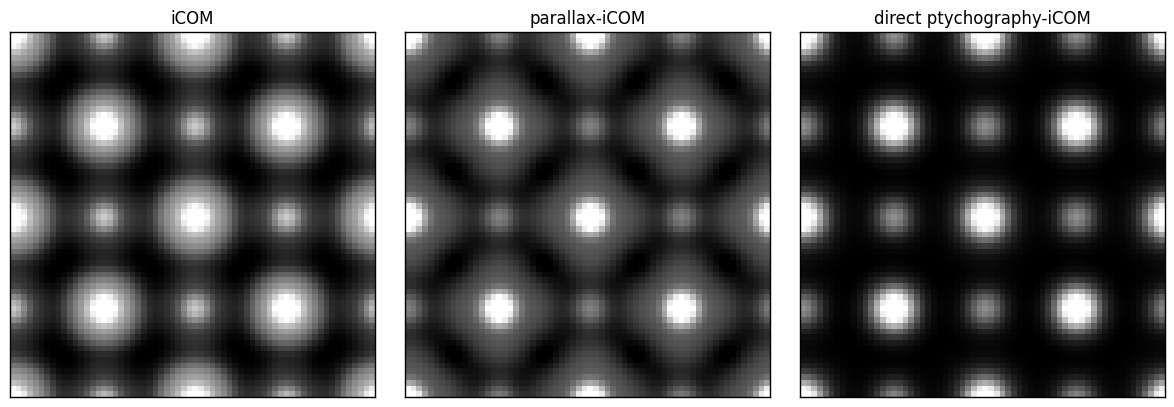

In [12]:
ibf_icom_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='none',use_center_of_mass_weighting=True).obj
parallax_icom_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='parallax',use_center_of_mass_weighting=True).obj
direct_ptychography_icom_obj = direct_ptychography_classes[1][0].reconstruct(deconvolution_kernel='full',use_center_of_mass_weighting=True).obj

em.visualization.show_2d(
    [
        np.tile(ibf_icom_obj,(2,2)),
        np.tile(parallax_icom_obj,(2,2)),
        np.tile(direct_ptychography_icom_obj,(2,2))
    ],
    title=["iCOM","parallax-iCOM","direct ptychography-iCOM"]
);

### Effect of Aberrations and Dose
These six permutations can be obtained using the convenience wrapper `_reconstruct_all_permutations()`

In [13]:
kwargs = {
    "title":[
        ["incoherent BF","parallax (phase-flipped)","direct ptychography",],
        ["iCOM","parallax + iCOM", "direct ptychography + iCOM"]
    ],
    "norm":"minmax",
    "axsize":(3,3),
}

  0%|          | 0/6 [00:00<?, ?it/s]

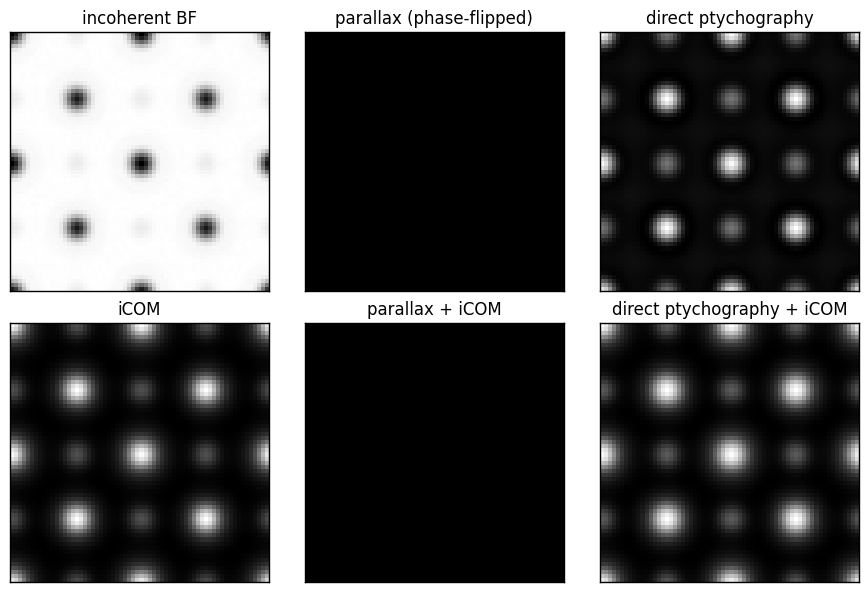

In [14]:
# in-focus, high dose
recons = direct_ptychography_classes[0][0]._reconstruct_all_permutations()
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    [
        recons_tiled[:3],
        recons_tiled[3:],
    ],
    **kwargs
);

  0%|          | 0/6 [00:00<?, ?it/s]

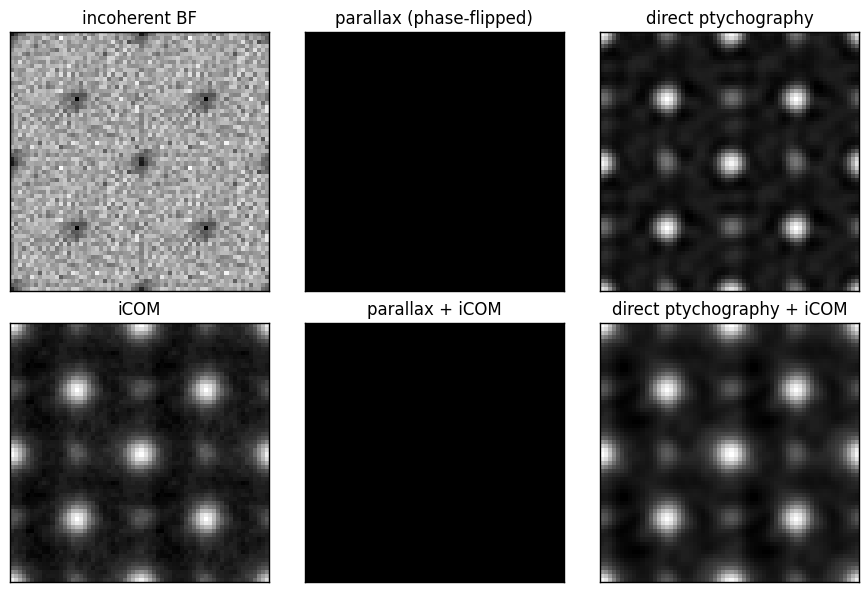

In [15]:
# in-focus, low dose
recons = direct_ptychography_classes[0][1]._reconstruct_all_permutations()
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    [
        recons_tiled[:3],
        recons_tiled[3:],
    ],
    **kwargs
);

  0%|          | 0/6 [00:00<?, ?it/s]

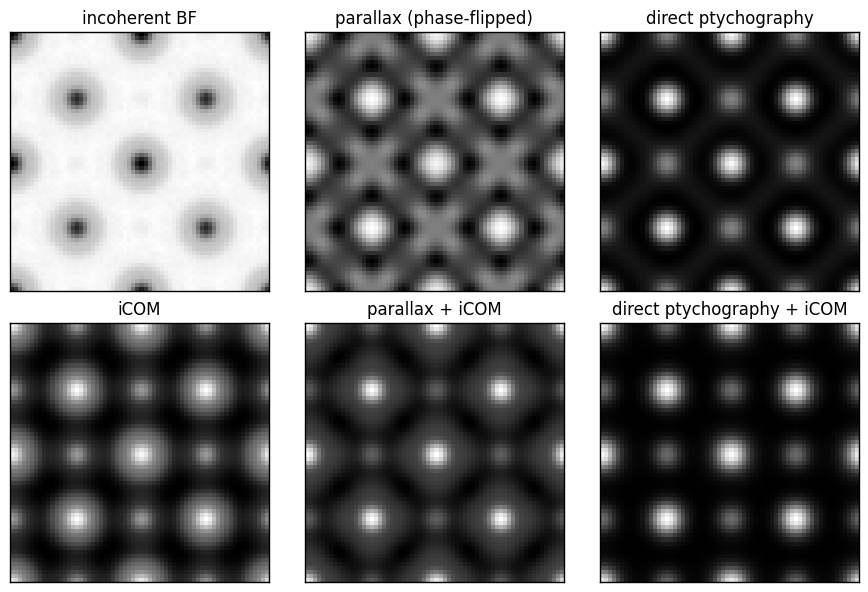

In [16]:
# defocus, high dose
recons = direct_ptychography_classes[1][0]._reconstruct_all_permutations()
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    [
        recons_tiled[:3],
        recons_tiled[3:],
    ],
    **kwargs
);

  0%|          | 0/6 [00:00<?, ?it/s]

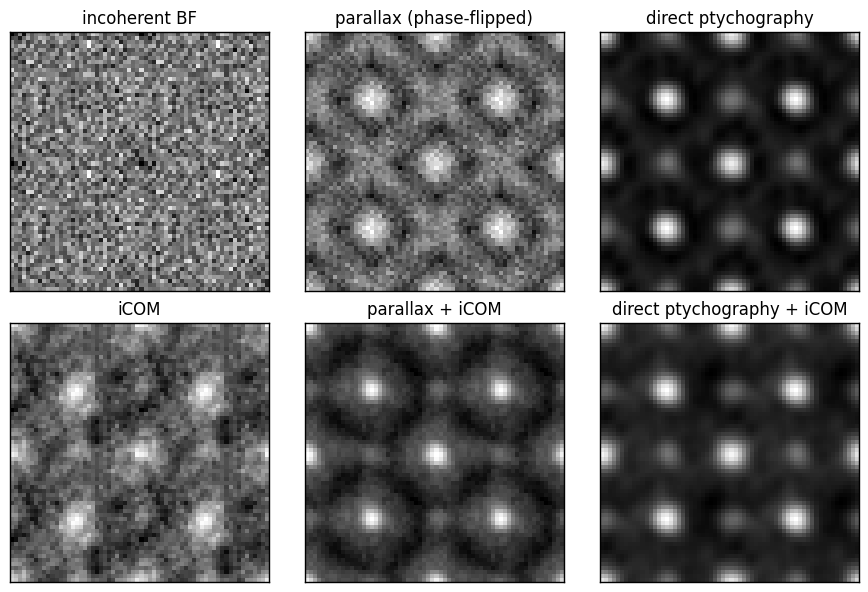

In [17]:
# defocus, low dose
recons = direct_ptychography_classes[1][1]._reconstruct_all_permutations()
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    [
        recons_tiled[:3],
        recons_tiled[3:],
    ],
    **kwargs
);

  0%|          | 0/6 [00:00<?, ?it/s]

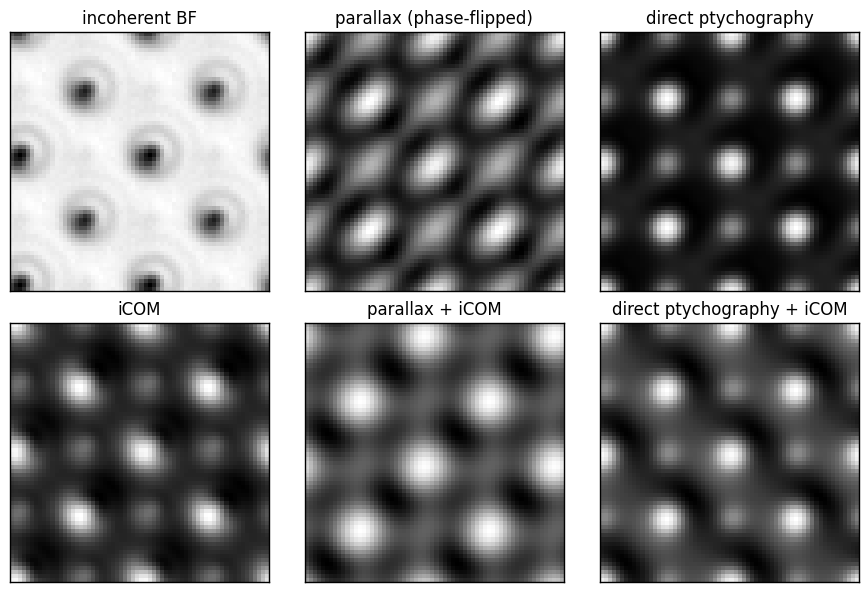

In [18]:
# defocus + coma, high dose
recons = direct_ptychography_classes[2][0]._reconstruct_all_permutations()
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    [
        recons_tiled[:3],
        recons_tiled[3:],
    ],
    **kwargs
);

  0%|          | 0/6 [00:00<?, ?it/s]

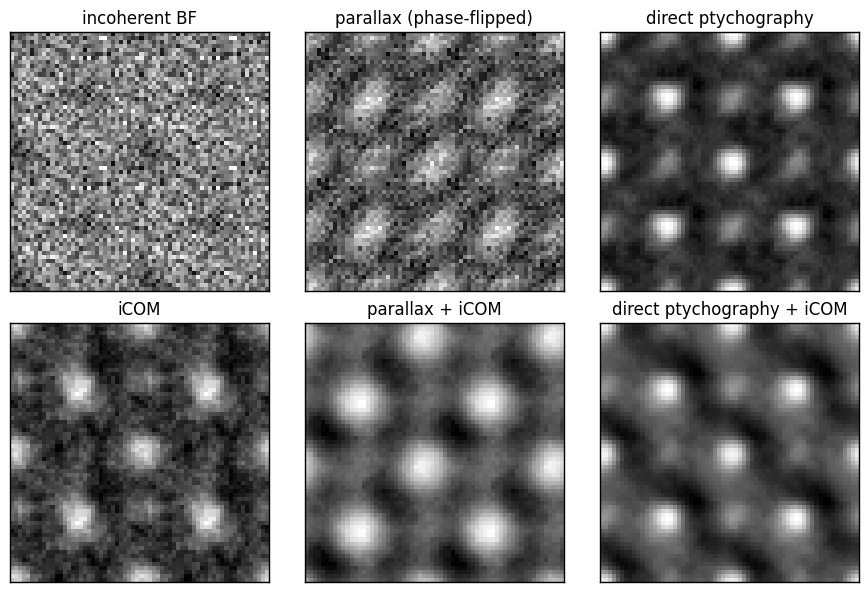

In [19]:
# defocus + coma, low dose
recons = direct_ptychography_classes[2][1]._reconstruct_all_permutations()
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    [
        recons_tiled[:3],
        recons_tiled[3:],
    ],
    **kwargs
);

### Upsampling

For `deconvolution_kernel != 'none'`, we can upsample our sub-sampled reconstructions to recover information.  
Note that this does not work for incoherent BF and pure iCOM.

  0%|          | 0/6 [00:00<?, ?it/s]

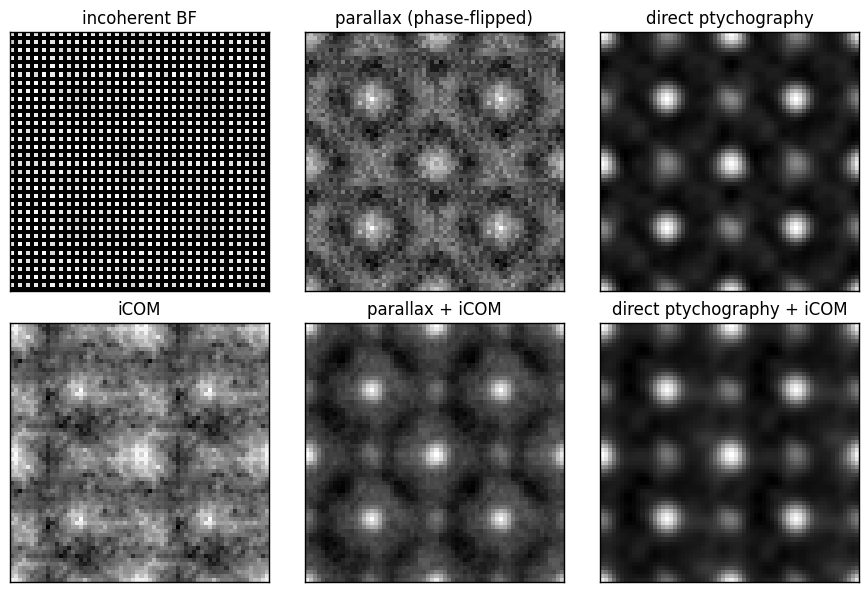

In [20]:
subsampled_noisy_dataset = add_poisson_noise(
    dataset[1,0,::2,::2],
    1e4
)
subsampled_noisy_direct_ptychography_class = direct_ptycho_object(
    subsampled_noisy_dataset,
    aberrations_flat[1],
    device='gpu'
)

recons = subsampled_noisy_direct_ptychography_class._reconstruct_all_permutations(
    upsampling_factor=2
)
recons_tiled = [np.tile(recon,(2,2)) for recon in recons]

em.visualization.show_2d(
    [
        recons_tiled[:3],
        recons_tiled[3:],
    ],
    **kwargs
);

## Parameter Estimation

Above, we used the known simulated aberration coefficients. When these are not known, we provide two ways to estimate them:
1. Hyperparameter optimization, minimizing the variance across the aligned stack
2. Direct fitting, using either pairwise cross-correlation (slower, good if no good initial guess) or cross-correlation against a reference (faster, good if starting from a reasonable guess)

In [21]:
direct_ptychography_classes[1][0].optimize_hyperparameters(
    aberration_coefs={
        "C10":em.diffractive_imaging.direct_ptychography.OptimizationParameter(
            0,200
        )
    },
    n_trials=250,
    deconvolution_kernel='parallax',
);

  0%|          | 0/250 [00:00<?, ?it/s]

Optimized parameters: {'C10': 62.31420684789232}


In [26]:
direct_ptychography_classes[1][0].fit_hyperparameters(
    use_reference=False,
    bin_factors=(3,2,1),
);

Aligning (pairwise):   0%|          | 0/3 [00:00<?, ?it/s]

Fitted parameters: {'C10': 43.35325622558594, 'C12': 17.286579132080078, 'phi12': -0.9435448050498962, 'rotation_angle': 0.5735423564910889}


In [27]:
direct_ptychography_classes[1][0].fit_hyperparameters(
    use_reference=True,
    bin_factors=(3,2,1),
    aberration_coefs={"C10":25},
);

Aligning (reference):   0%|          | 0/3 [00:00<?, ?it/s]

Fitted parameters: {'C10': 25.92047882080078, 'C12': 3.5143167972564697, 'phi12': -1.3899887800216675, 'rotation_angle': 0.020967185497283936}


## Iterative Ptychography Comparison

For completeness, we also perform a single-slice iterative ptychography reconstruction.

In [88]:
pdset = em.diffractive_imaging.PtychographyDatasetRaster.from_dataset4dstem(
    subsampled_noisy_dataset
)

pdset.preprocess(
    force_com_rotation=0,
    force_com_transpose=0,
    plot_com=False,
    probe_energy=300e3,
)

Forcing best fit rotation to 0 degrees.
Forcing transpose of intensities to 0.


Normalizing intensities:   0%|          | 0/256 [00:00<?, ?probe position/s]

In [89]:
iterative_ptycho = em.diffractive_imaging.PtychoLite.from_dataset(
    dset=pdset,
    num_slices=1,
    num_probes=1,
    energy=300e3,
    polar_parameters= aberrations_flat[1],
    semiangle_cutoff=20,
    obj_padding_px=(0,0),
).reconstruct(
    num_iter=100,
    device="gpu",
    batch_size=128
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [90]:
direct_ptycho_phase = subsampled_noisy_direct_ptychography_class.reconstruct(
    upsampling_factor=2
).corrected_stack.mean(0).cpu()
direct_ptycho_amplitude = subsampled_noisy_direct_ptychography_class.corrected_stack_amplitude.mean(0).cpu()

  0%|          | 0/1741 [00:00<?, ?it/s]

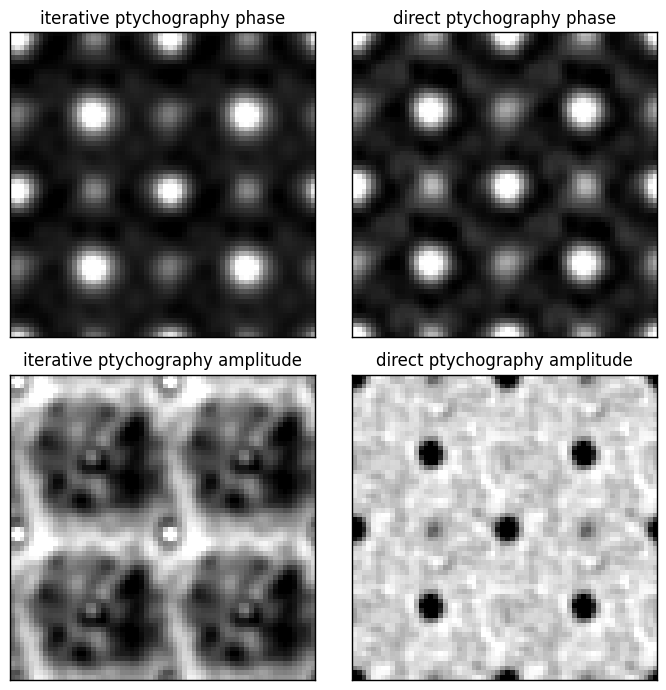

In [91]:
em.visualization.show_2d(
    [
        [
            np.tile(np.angle(iterative_ptycho.obj[0]),(2,2)),
            np.tile(direct_ptycho_phase,(2,2)),
        ],
        [
            np.tile(np.abs(iterative_ptycho.obj[0]),(2,2)),
            np.tile(direct_ptycho_amplitude,(2,2))
        ]
    ],
    title=[
        ["iterative ptychography phase","direct ptychography phase"],
        ["iterative ptychography amplitude","direct ptychography amplitude"]
    ],
    axsize=(3.5,3.5)
);